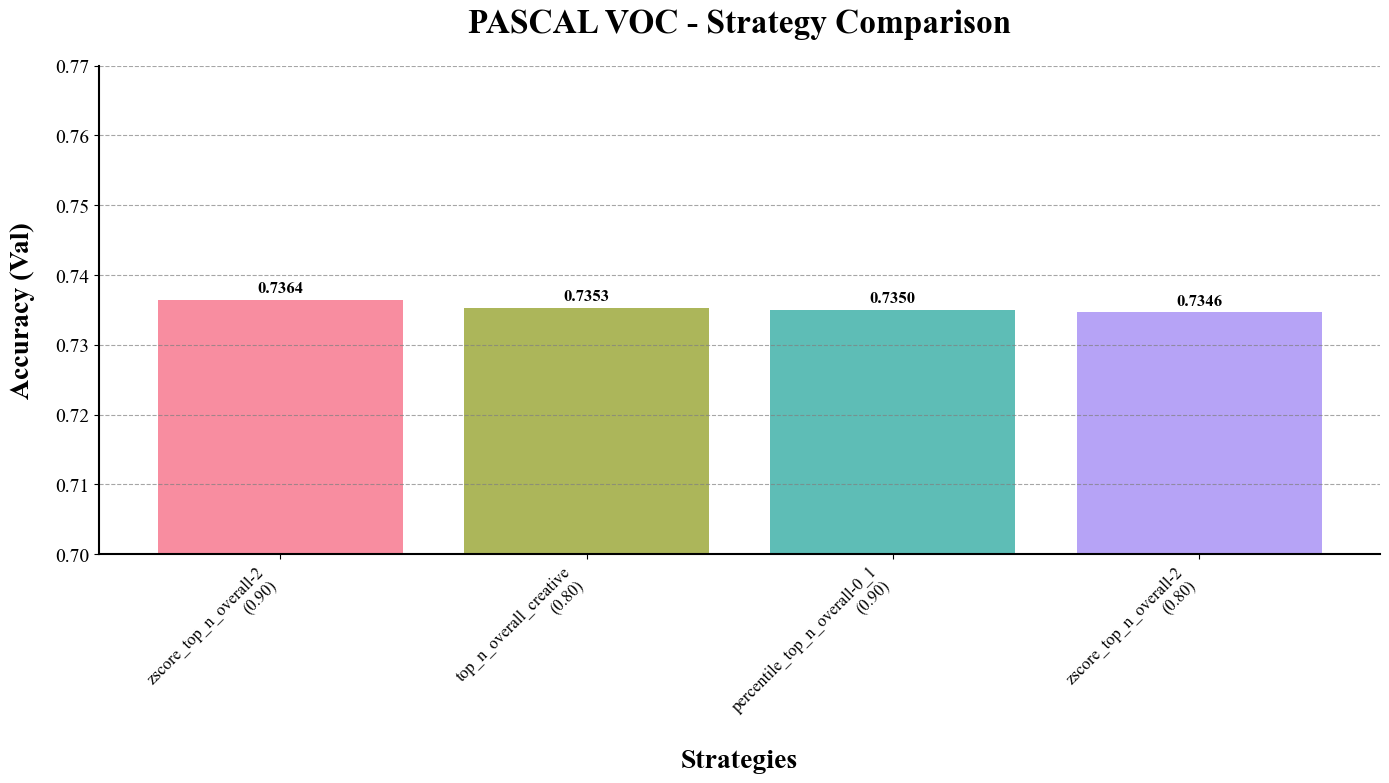

Strategy Comparisons:

Examples per class: 2
  Best strategy: zscore_top_n_overall-2 (param: 0.90)
  Best accuracy: 0.7364
  top_n_overall_creative (param: 0.80):
    Accuracy: 0.7353
    Difference from best: 0.15%
  percentile_top_n_overall-0_1 (param: 0.90):
    Accuracy: 0.7350
    Difference from best: 0.19%
  zscore_top_n_overall-2 (param: 0.80):
    Accuracy: 0.7346
    Difference from best: 0.24%


In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import numpy as np
import re

# Constants
BASE_FOLDER = '/Users/andrew/Thesis/smart-image-augmentation/results/experiment-with-strategies'

def extract_info_from_filename(filename):
    # Extract pascal-0-X, strategy name, and parameter value
    match = re.match(r'pascal-0-(\d+)-(.+)-(\d+[._]\d+)\.csv', filename)
    if match:
        examples_per_class = int(match.group(1))
        strategy = match.group(2)
        param_value = float(match.group(3).replace('_', '.'))
        return examples_per_class, strategy, param_value
    else:
        print(f"Warning: Could not extract info from {filename}")
        return None, None, None

def load_and_process_data(folder):
    all_files = glob.glob(os.path.join(folder, "*.csv"))
    if not all_files:
        print(f"No CSV files found in {folder}")
        return None
    
    results = []
    for filename in all_files:
        df = pd.read_csv(filename)
        examples_per_class, strategy, param_value = extract_info_from_filename(os.path.basename(filename))
        if examples_per_class is not None:
            filtered_df = df[(df['metric'] == 'Accuracy') & (df['split'] == 'Validation')]
            if not filtered_df.empty:
                max_accuracy = filtered_df['value'].max()
                results.append({
                    'examples_per_class': examples_per_class,
                    'strategy': strategy,
                    'param_value': param_value,
                    'accuracy': max_accuracy
                })
            else:
                print(f"Warning: No validation accuracy data found in {filename}")
    
    if not results:
        print("No valid data extracted from any file.")
        return None
    
    return pd.DataFrame(results)

def plot_strategy_results(results):
    if results.empty:
        print("No data to plot.")
        return

    plt.figure(figsize=(14, 8))
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
    
    # Sort strategies by accuracy
    results_sorted = results.sort_values('accuracy', ascending=False)
    
    # Create color palette
    color_palette = sns.color_palette("husl", n_colors=len(results_sorted))
    
    # Create bar plot
    bars = plt.bar(range(len(results_sorted)), results_sorted['accuracy'], align='center', 
                   alpha=0.8, color=color_palette)
    
    # Customize the plot
    plt.title('PASCAL VOC - Strategy Comparison', fontsize=24, fontweight='bold', y=1.05)
    plt.xlabel('Strategies', fontsize=20, fontweight='bold', labelpad=15)
    plt.ylabel('Accuracy (Val)', fontsize=20, fontweight='bold', labelpad=15)
    
    # Set y-axis limits and ticks
    plt.ylim(0.70, 0.77)  # Adjust as needed to fit your data
    plt.yticks(np.arange(0.70, 0.77, 0.01), fontsize=14)
    
    # Customize x-axis ticks
    plt.xticks(range(len(results_sorted)), 
               [f"{s}\n({p:.2f})" for s, p in zip(results_sorted['strategy'], results_sorted['param_value'])], 
               fontsize=12, rotation=45, ha='right')
    
    # Add value labels on top of each bar
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.0005,
                 f'{height:.4f}',
                 ha='center', va='bottom', fontsize=12, fontweight='bold')
    
    # Customize grid
    plt.grid(axis='y', linestyle='--', alpha=0.7, color='gray')
    
    # Remove top and right spines
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    
    # Enhance remaining spines
    plt.gca().spines['left'].set_linewidth(1.5)
    plt.gca().spines['bottom'].set_linewidth(1.5)
    
    plt.tight_layout()
    plt.savefig('pascal_strategy_comparison_bar_enhanced.png', dpi=300, bbox_inches='tight')
    plt.savefig('pascal_strategy_comparison_bar_enhanced.pdf', bbox_inches='tight')
    plt.show()

def print_strategy_comparisons(results):
    if results.empty:
        print("No data for comparison.")
        return

    print("Strategy Comparisons:")
    for examples_per_class in results['examples_per_class'].unique():
        print(f"\nExamples per class: {examples_per_class}")
        group = results[results['examples_per_class'] == examples_per_class].sort_values('accuracy', ascending=False)
        best_strategy = group.iloc[0]
        print(f"  Best strategy: {best_strategy['strategy']} (param: {best_strategy['param_value']:.2f})")
        print(f"  Best accuracy: {best_strategy['accuracy']:.4f}")
        
        for _, row in group.iloc[1:].iterrows():
            diff = (best_strategy['accuracy'] - row['accuracy']) / row['accuracy'] * 100
            print(f"  {row['strategy']} (param: {row['param_value']:.2f}):")
            print(f"    Accuracy: {row['accuracy']:.4f}")
            print(f"    Difference from best: {diff:.2f}%")

# Main execution
results = load_and_process_data(BASE_FOLDER)

if results is not None and not results.empty:
    plot_strategy_results(results)
    print_strategy_comparisons(results)
else:
    print("Error: Could not load data for the strategies.")